In [83]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [84]:
#Hiper parametros
k_size=31
sigma=10

In [85]:
def create_gauss_filter(h, w, k_size, sigma):
    nucleo_g = cv.getGaussianKernel(ksize=k_size, sigma=sigma) 
    n=nucleo_g*nucleo_g. T
    z=np.zeros((h,w))
    pad_w=w//2-k_size//2
    pad_h=h//2-k_size//2
    padding=((pad_h,pad_h),(pad_w,pad_w))
    z=np.pad(n,padding,'constant', constant_values=np.zeros_like(padding))


    # Sacamos la ultima fila o columna si es par, para que queden del mismo tamaño
    if (w % 2) == 0:
        z=z[:,0:-1]
    if (h % 2) == 0:
        z=z[0:-1,:]

    return (z,np.fft.fft2(z))


Implementar la función **create_gauss_filter(h, w, k_size, sigma)** para crear filtros gaussianos para
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada
de Fourier.
1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una
imagen para validar el funcionamiento en el dominio espectral.
2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of
focus measure operators in shape-from-focus”

In [86]:
img = cv.imread('chewbacca.jpg', cv.IMREAD_GRAYSCALE)
img.shape

(756, 1200)

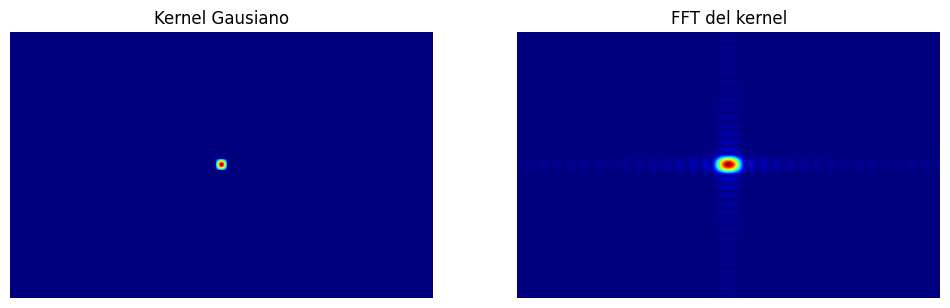

In [87]:
kernel, kernel_tf = create_gauss_filter(h=img.shape[0], w=img.shape[1], k_size=k_size, sigma=sigma)
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
tf_shifted = np.fft.fftshift(kernel_tf)
plt.imshow(np.abs(tf_shifted), cmap='jet')

In [88]:
img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf

img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

plt.figure(figsize=(8,8))
plt.imshow(img_gauss, cmap='gray')
plt.title('Desenfoque gausiano')

ValueError: operands could not be broadcast together with shapes (756,1200) (757,1201) 

2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

In [ ]:
def method1(img):
    #Step 1: Compute F which is the Fourier Transform representation of image I
    img_fft = np.fft.fft2(img)
    #Step 2: Find Fc which is obtained by shifting the origin of F to centre.
    tf_shifted = np.fft.fftshift(img_fft)
    #Step 3: Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I.
    tf_shifted_abs =np.abs(tf_shifted)
    #Step 4: Calculate M = max (AF) where M is the maximum value of the frequency component in F.
    M = np.max(tf_shifted_abs)
    #Step 5: Calculate T H = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
    thres=M/1000
    out=np.array([1 if thres>i else 0 for i in tf_shifted_abs.flatten()])
    #Step 6: Calculate Image Quality measure (FM) from equation (1)
    return np.sum(out)/(img.shape[0]*img.shape[1])

method1(img)


0.9968022486772486

Aplico para filtrado por convolusion y espectral

0.9985372574955909

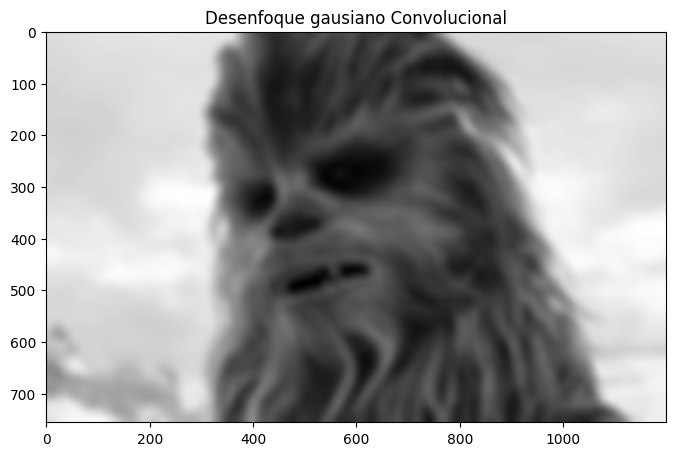

In [ ]:
#Convolucional

img_gauss = cv.GaussianBlur(img, ksize=(k_size,k_size), sigmaX=sigma,  sigmaY=sigma)
plt.figure(figsize=(8,8))
plt.imshow(img_gauss, cmap='gray')
plt.title('Desenfoque gausiano Convolucional')

method1(img_gauss)

0.9988040123456791

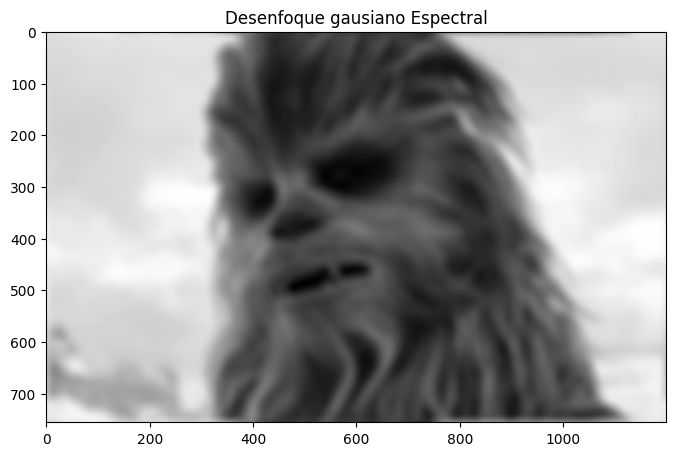

In [ ]:
#Espectral

img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf

img_gauss_e = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

plt.figure(figsize=(8,8))
plt.imshow(img_gauss_e, cmap='gray')
plt.title('Desenfoque gausiano Espectral')

method1(img_gauss_e)

3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape-from-focus”

### Gray-level variance (STA3)

\begin{equation}
\phi_{x,y} =\sum_{(i,j) \in \Omega(x,y)} (I(i,j) - \mu)   ^2
\end{equation}

In [ ]:
## Gray-level variance (STA3)
def STA3(img):
    mu=np.mean(img)
    return np.sum(np.frompyfunc(lambda x: (x-mu)**2, 1, 1)(img))

print(STA3(img))

print(STA3(img_gauss))

print(STA3(img_gauss_e))

5434149420.091484
5190098219.695296
5143392472.61049


Se nota que la metrica da menor, para los filtros gaussianos. Creo que tiene sentido dado a es un filtro que suaviza y de alguna manera promedia los valores para estar mas cerca de la media.